In [1]:
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
!tar xfz images.tar.gz
!rm images.tar.gz

--2024-04-17 19:09:59--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz [following]
--2024-04-17 19:10:00--  https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz
Reusing existing connection to thor.robots.ox.ac.uk:443.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  28.9MB/s    in 27s     

2024-04-17 19:10:27 (28.0 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]



In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np

%matplotlib inline

In [3]:
def display_images(l,titles=None,fontsize=10):
    n=len(l)
    fig,ax = plt.subplots(1, 2)
    for i,im in enumerate(l):
        ax[i].imshow(im)
        ax[i].axis('off')
        if titles is not None:
            ax[i].set_title(titles[i],fontsize=fontsize)
    fig.set_size_inches(fig.get_size_inches()*10)
    plt.tight_layout()
    plt.show()

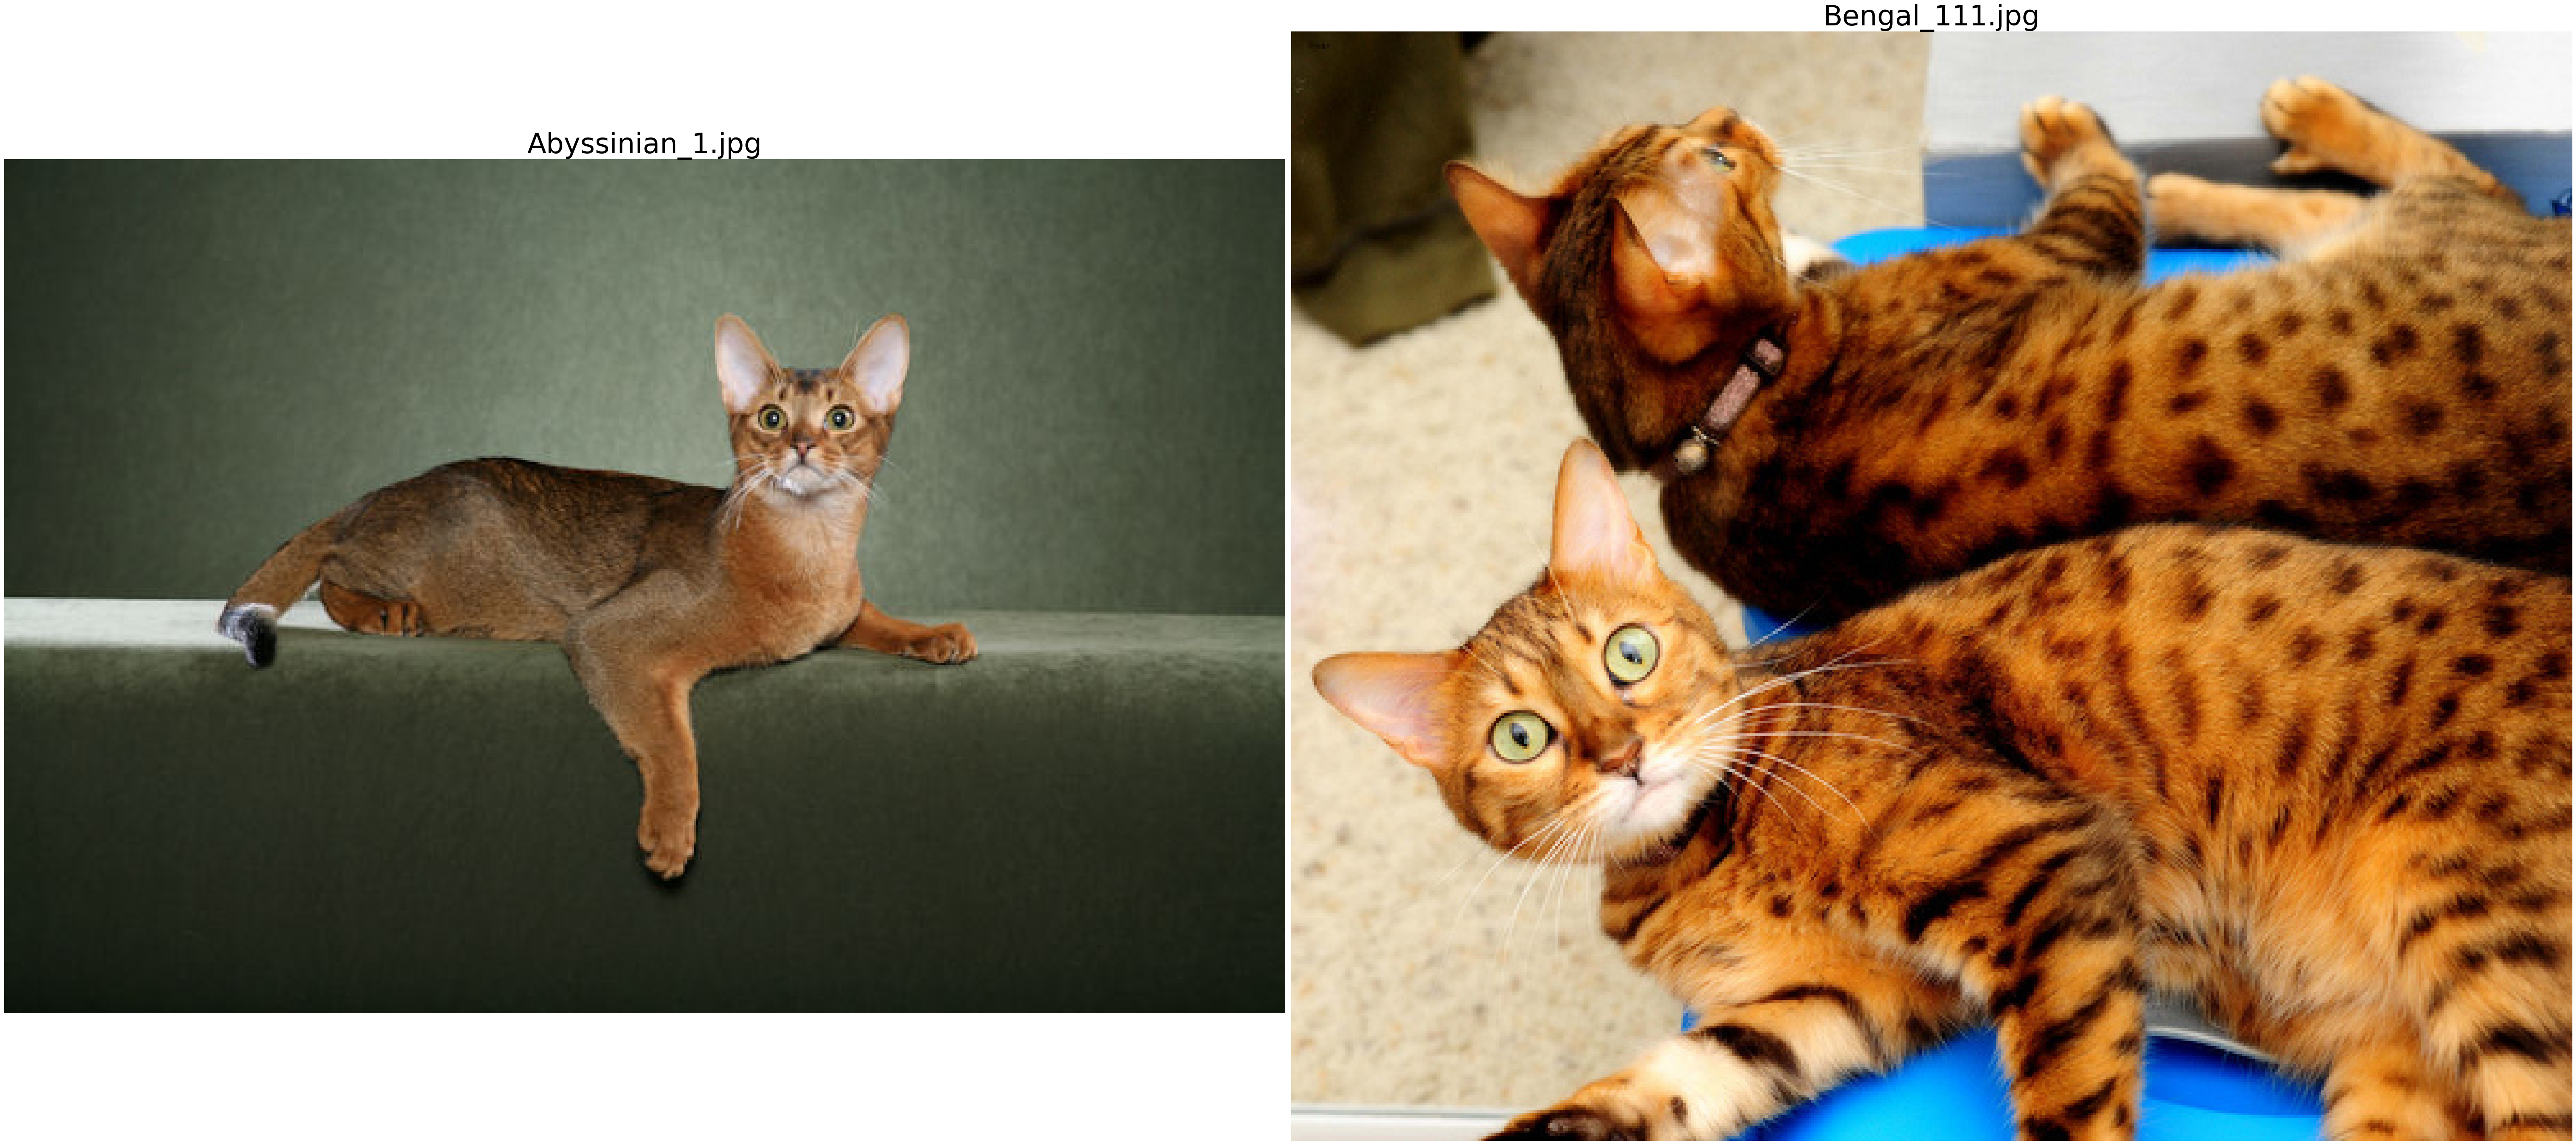

In [ ]:
# Загрузка изображений
image1 = Image.open("images/Abyssinian_1.jpg", "r")
image2 = Image.open("images/Bengal_111.jpg", "r")

# Отображение изображений
display_images([image1, image2], titles=['Abyssinian_1.jpg', 'Bengal_111.jpg'], fontsize=50)

In [4]:
!mkdir Dog_Cat
!mkdir Dog_Cat/Dog
!mkdir Dog_Cat/Cat

In [5]:
import os
import shutil

source_dir = "images/"
dest_dir_upper = "Dog_Cat/Cat"
dest_dir_lower = "Dog_Cat/Dog"

files = os.listdir(source_dir)

for file in files:
    if file[0].isupper():
        shutil.move(os.path.join(source_dir, file), os.path.join(dest_dir_upper, file))
    elif file[0].islower():
        shutil.move(os.path.join(source_dir, file), os.path.join(dest_dir_lower, file))

In [6]:
!rm -r images

### 1. GAN (64x64)

In [7]:
# Загрузка датасета
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset = datasets.ImageFolder('Dog_Cat/', transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [8]:
# Определение модели дискриминатора
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [9]:
# Определение модели генератора
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100, 256, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

In [10]:
# Инициализация моделей и оптимизаторов
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
discriminator = Discriminator().to(device)
generator = Generator().to(device)
criterion = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [11]:
# Функция обучения дискриминатора
def train_discriminator(images, labels):
    discriminator.zero_grad()

    real_images = images.to(device)
    real_labels = torch.ones((real_images.size(0), 1)).to(device)

    fake_images = generator(torch.randn(images.size(0), 100, 1, 1).to(device))
    fake_labels = torch.zeros((fake_images.size(0), 1)).to(device)

    real_labels = torch.unsqueeze(real_labels, dim=2)
    real_labels = torch.unsqueeze(real_labels, dim=3)
    real_predictions = discriminator(real_images)
    real_loss = criterion(real_predictions, real_labels.expand_as(real_predictions))
    real_loss.backward()


    fake_predictions = discriminator(fake_images.detach())
    fake_labels_expanded = fake_labels.unsqueeze(2).unsqueeze(3).expand_as(fake_predictions)
    fake_loss = criterion(fake_predictions, fake_labels_expanded)
    fake_loss.backward()

    d_optimizer.step()

    return real_loss + fake_loss

In [12]:
# Функция обучения генератора
def train_generator(images):
    generator.zero_grad()

    generated_images = generator(torch.randn(images.size(0), 100, 1, 1).to(device))
    predictions = discriminator(generated_images)

    target_labels = torch.ones_like(predictions).to(device)

    g_loss = criterion(predictions, target_labels)
    g_loss.backward()

    g_optimizer.step()

    return g_loss

Epoch [0/100], Step [0/58], D_loss: 0.0686, G_loss: 5.5345
Epoch [10/100], Step [0/58], D_loss: 0.0012, G_loss: 7.7284
Epoch [20/100], Step [0/58], D_loss: 0.0003, G_loss: 9.0567
Epoch [30/100], Step [0/58], D_loss: 0.0001, G_loss: 10.2076
Epoch [40/100], Step [0/58], D_loss: 0.0001, G_loss: 10.5734
Epoch [50/100], Step [0/58], D_loss: 0.0000, G_loss: 11.2840
Epoch [60/100], Step [0/58], D_loss: 0.0000, G_loss: 11.7439
Epoch [70/100], Step [0/58], D_loss: 0.0000, G_loss: 12.4305
Epoch [80/100], Step [0/58], D_loss: 0.0000, G_loss: 12.2263
Epoch [90/100], Step [0/58], D_loss: 0.0000, G_loss: 13.0437


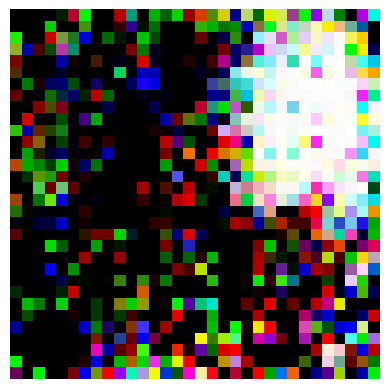

In [ ]:
# Обучение GAN
num_epochs = 100

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        # Обучение дискриминатора
        d_loss = train_discriminator(images, labels)

        # Обучение генератора
        g_loss = train_generator(images)

                # Вывод прогресса на каждой 10-ой эпохе на нулевом шаге
        if epoch % 10 == 0 and i == 0:
            print('Epoch [{}/{}], Step [{}/{}], D_loss: {:.4f}, G_loss: {:.4f}'.format(
                epoch, num_epochs, i, len(dataloader), d_loss.item(), g_loss.item()
            ))

        # Прорисовка полученной картинки после обучения генератора в конце
        if epoch == num_epochs - 1 and i == len(dataloader) - 1:
            generated_images = generator(torch.randn(1, 100, 1, 1).to(device))
            plt.imshow(generated_images.squeeze().detach().cpu().permute(1, 2, 0).numpy())
            plt.axis('off')
            plt.show()

### 2. GAN (128x128)

In [ ]:
# Загрузка датасета
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset = datasets.ImageFolder('Dog_Cat/', transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [ ]:
# Определение модели дискриминатора
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# Определение модели генератора
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100, 256, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# Инициализация моделей и оптимизаторов
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
discriminator = Discriminator().to(device)
generator = Generator().to(device)
criterion = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
# Функция обучения дискриминатора
def train_discriminator(images, labels):
    discriminator.zero_grad()

    real_images = images.to(device)
    real_labels = torch.ones((real_images.size(0), 1)).to(device)

    fake_images = generator(torch.randn(images.size(0), 100, 1, 1).to(device))
    fake_labels = torch.zeros((fake_images.size(0), 1)).to(device)

    real_labels = torch.unsqueeze(real_labels, dim=2)
    real_labels = torch.unsqueeze(real_labels, dim=3)
    real_predictions = discriminator(real_images)
    real_loss = criterion(real_predictions, real_labels.expand_as(real_predictions))
    real_loss.backward()


    fake_predictions = discriminator(fake_images.detach())
    fake_labels_expanded = fake_labels.unsqueeze(2).unsqueeze(3).expand_as(fake_predictions)
    fake_loss = criterion(fake_predictions, fake_labels_expanded)
    fake_loss.backward()

    d_optimizer.step()

    return real_loss + fake_loss

In [ ]:
# Функция обучения генератора
def train_generator(images):
    generator.zero_grad()

    generated_images = generator(torch.randn(images.size(0), 100, 1, 1).to(device))
    predictions = discriminator(generated_images)

    target_labels = torch.ones_like(predictions).to(device)

    g_loss = criterion(predictions, target_labels)
    g_loss.backward()

    g_optimizer.step()

    return g_loss

Epoch [0/100], Step [0/58], D_loss: 1.4817, G_loss: 1.6580
Epoch [10/100], Step [0/58], D_loss: 0.0010, G_loss: 7.9426
Epoch [20/100], Step [0/58], D_loss: 0.0002, G_loss: 9.4087
Epoch [30/100], Step [0/58], D_loss: 0.0001, G_loss: 10.2980
Epoch [40/100], Step [0/58], D_loss: 0.0001, G_loss: 10.9810
Epoch [50/100], Step [0/58], D_loss: 0.0000, G_loss: 11.6642
Epoch [60/100], Step [0/58], D_loss: 0.0000, G_loss: 12.3484
Epoch [70/100], Step [0/58], D_loss: 0.0000, G_loss: 12.3408
Epoch [80/100], Step [0/58], D_loss: 0.0000, G_loss: 12.9553
Epoch [90/100], Step [0/58], D_loss: 0.0000, G_loss: 13.5460


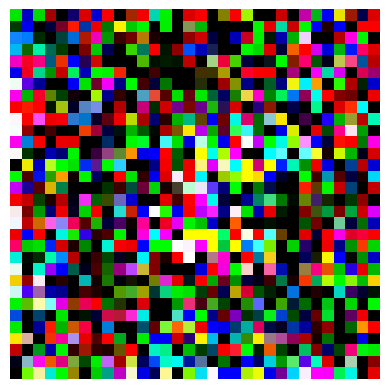

In [ ]:
# Обучение GAN
num_epochs = 100

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        # Обучение дискриминатора
        d_loss = train_discriminator(images, labels)

        # Обучение генератора
        g_loss = train_generator(images)

                # Вывод прогресса на каждой 10-ой эпохе на нулевом шаге
        if epoch % 10 == 0 and i == 0:
            print('Epoch [{}/{}], Step [{}/{}], D_loss: {:.4f}, G_loss: {:.4f}'.format(
                epoch, num_epochs, i, len(dataloader), d_loss.item(), g_loss.item()
            ))

        # Прорисовка полученной картинки после обучения генератора в конце
        if epoch == num_epochs - 1 and i == len(dataloader) - 1:
            generated_images = generator(torch.randn(1, 100, 1, 1).to(device))
            plt.imshow(generated_images.squeeze().detach().cpu().permute(1, 2, 0).numpy())
            plt.axis('off')
            plt.show()

### 3. GAN (256x256)

In [ ]:
# Загрузка датасета
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset = datasets.ImageFolder('Dog_Cat/', transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [7]:
# Определение модели дискриминатора
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [8]:
# Определение модели генератора
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100, 256, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

In [9]:
# Инициализация моделей и оптимизаторов
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
discriminator = Discriminator().to(device)
generator = Generator().to(device)
criterion = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [10]:
# Функция обучения дискриминатора
def train_discriminator(images, labels):
    discriminator.zero_grad()

    real_images = images.to(device)
    real_labels = torch.ones((real_images.size(0), 1)).to(device)

    fake_images = generator(torch.randn(images.size(0), 100, 1, 1).to(device))
    fake_labels = torch.zeros((fake_images.size(0), 1)).to(device)

    real_labels = torch.unsqueeze(real_labels, dim=2)
    real_labels = torch.unsqueeze(real_labels, dim=3)
    real_predictions = discriminator(real_images)
    real_loss = criterion(real_predictions, real_labels.expand_as(real_predictions))
    real_loss.backward()


    fake_predictions = discriminator(fake_images.detach())
    fake_labels_expanded = fake_labels.unsqueeze(2).unsqueeze(3).expand_as(fake_predictions)
    fake_loss = criterion(fake_predictions, fake_labels_expanded)
    fake_loss.backward()

    d_optimizer.step()

    return real_loss + fake_loss

In [11]:
# Функция обучения генератора
def train_generator(images):
    generator.zero_grad()

    generated_images = generator(torch.randn(images.size(0), 100, 1, 1).to(device))
    predictions = discriminator(generated_images)

    target_labels = torch.ones_like(predictions).to(device)

    g_loss = criterion(predictions, target_labels)
    g_loss.backward()

    g_optimizer.step()

    return g_loss

Epoch [0/80], Step [0/58], D_loss: 1.3914, G_loss: 1.9387
Epoch [10/80], Step [0/58], D_loss: 0.0012, G_loss: 8.0709
Epoch [20/80], Step [0/58], D_loss: 0.0003, G_loss: 9.4641
Epoch [30/80], Step [0/58], D_loss: 0.0001, G_loss: 10.4364
Epoch [40/80], Step [0/58], D_loss: 0.0001, G_loss: 10.8997
Epoch [50/80], Step [0/58], D_loss: 0.0000, G_loss: 11.5143
Epoch [60/80], Step [0/58], D_loss: 0.0000, G_loss: 11.8718
Epoch [70/80], Step [0/58], D_loss: 0.0000, G_loss: 12.3790


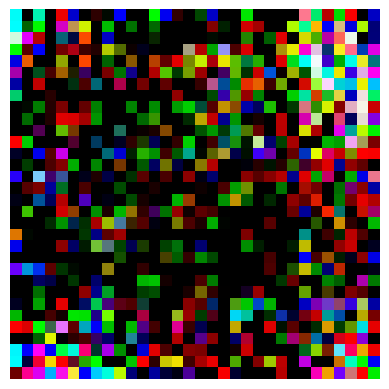

In [ ]:
# Обучение GAN
num_epochs = 80

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        # Обучение дискриминатора
        d_loss = train_discriminator(images, labels)

        # Обучение генератора
        g_loss = train_generator(images)

                # Вывод прогресса на каждой 10-ой эпохе на нулевом шаге
        if epoch % 10 == 0 and i == 0:
            print('Epoch [{}/{}], Step [{}/{}], D_loss: {:.4f}, G_loss: {:.4f}'.format(
                epoch, num_epochs, i, len(dataloader), d_loss.item(), g_loss.item()
            ))

        # Прорисовка полученной картинки после обучения генератора в конце
        if epoch == num_epochs - 1 and i == len(dataloader) - 1:
            generated_images = generator(torch.randn(1, 100, 1, 1).to(device))
            plt.imshow(generated_images.squeeze().detach().cpu().permute(1, 2, 0).numpy())
            plt.axis('off')
            plt.show()